In [1]:
from training.model import *
from training.datasets import *
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
BASE_DIR = ''
BATCH_SIZE = 100
test_checkpoint = 'checkpoints/PlaqueTissueClassifier_Epoch_1_AdamW.pth'
plaque_dir = BASE_DIR + "tiles"

In [3]:
model = PlaqueTissueClassifier().to('cpu')
checkpoint_path = os.path.join(BASE_DIR, test_checkpoint)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# handles if model was parallelized during training
new_state_dict = dict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace('module.', '') # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Normalize for pretrained weights
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

plaque_holdout_set = PlaqueDataset(os.path.join(plaque_dir, 'hold-out.csv'), os.path.join(plaque_dir, 'hold-out'), transform=test_transform)
plaque_holdout_loader = DataLoader(plaque_holdout_set, batch_size=BATCH_SIZE, shuffle=False)

/Users/oliviashen/anaconda3/envs/brainsec/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_18863/155974128.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializa

In [4]:
def plaque_roc(model, plaque_loader, class_names, device):
    # init metrics
    probabilities = []
    labels = []

    # Plaque inference
    for p_data in plaque_loader:
        # Run inference on batch
        p_images, p_labels = p_data[0].to(device,dtype=torch.float), p_data[1].to(device,dtype=torch.long)
        p_preds, _ = model(p_images)
        # get class probabilities
        probabilities.append(torch.nn.functional.sigmoid(p_preds.data).cpu().numpy())
        labels.append(p_labels.cpu().numpy())
    
    probabilities = np.concatenate(probabilities)
    labels = np.concatenate(labels)

    fpr, tpr, thresh, roc_auc = dict(), dict(), dict(), dict()
    for i in range(len(class_names)):
        fpr[class_names[i]], tpr[class_names[i]], thresh[class_names[i]] = roc_curve(labels[:, i], probabilities[:, i])
        roc_auc[class_names[i]] = auc(fpr[class_names[i]], tpr[class_names[i]])
    
    return fpr, tpr, thresh, roc_auc


In [5]:
def plot_roc(fpr, tpr):
    plt.figure()
    for key in fpr:
        plt.plot(fpr[key], tpr[key], label=f"ROC of class {key}")
    
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic for Plaque Holdout")
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def plot_fpr_tpr_curve(fpr, tpr, thresh):
    nrows = (len(fpr) / 2) + 1
    fig, axs = plt.subplots(nrows=nrows, ncols=2)
    for i in 

SyntaxError: invalid syntax (1456651785.py, line 4)

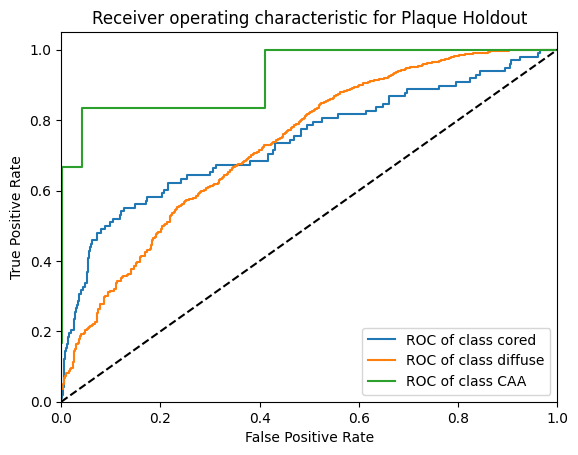

Class cored AUROC = 0.7390463563615701
Class diffuse AUROC = 0.7311508167744694
Class CAA AUROC = 0.9237600073617374


In [7]:
fpr, tpr, thresh, auc_roc = plaque_roc(model, plaque_holdout_loader, ['cored', 'diffuse', 'CAA'], 'cpu')
plot_roc(fpr, tpr)
for key in auc_roc:
    print(f"Class {key} AUROC = {auc_roc[key]}")